# Knockout gRNA Analysis

As part of our dataset, we have roughly 80000 gRNAs targetting approximately 18000 genes. On average, thats about 5 gRNAs per gene. We also filter these guide-RNAs by the number of mutagenic reads in order to improve the quality of the profiles. However, some of those gRNAs may not be as efficient as other gRNAs for a single gene, producing different repair outcome profiles which may be "noisy" when compared to others. We should decide on a mechanism to filter out those guide RNAs.


Analysis Plan
 - How many mutagenic reads does each gRNA have? What is the range? (Histograms and boxplots)
 - How many gRNAs does each gene have? (Histogram)
 - Can we say anything about the quality of the clustering? (Silhouette score, intra-cluster distance)
 - In order to say anything about the quality of the clustering, we need to decide what outcomes will be kept for analysis
 - How is the quality of the clustering impacted by raising the threshold on the number of genes?
 - How do we identify and filter out problematic gRNAs? (Grubbs)
 - After filtering, how many gRNAs does each gene have? (histogram)
 - How do we handle genes with 1 or 2 gRNAs? Should we have a limit?
 - How is the quality of clustering of gene profiles affected by removing problematics gRNAs? (boxplots)

In [1]:
from src.data.load_dataset import load_samples_01_to_06

df = load_samples_01_to_06(raw=True)
df.head(2)

loaded outcomes


fraction_per_barcode  \
Alias Gene          Barcode         outcome                                     
MB01  0610009B22Rik 0610009B22Rik-5 DELETION|-17|6||1bp              0.002066   
                    0610009B22Rik-4 DELETION|-10|2||1bp              0.002077   

                                                         mutEvents  \
Alias Gene          Barcode         outcome                          
MB01  0610009B22Rik 0610009B22Rik-5 DELETION|-17|6||1bp       2549   
                    0610009B22Rik-4 DELETION|-10|2||1bp       3757   

                                                         countEvents  
Alias Gene          Barcode         outcome                           
MB01  0610009B22Rik 0610009B22Rik-5 DELETION|-17|6||1bp         6778  
                    0610009B22Rik-4 DELETION|-10|2||1bp         8186

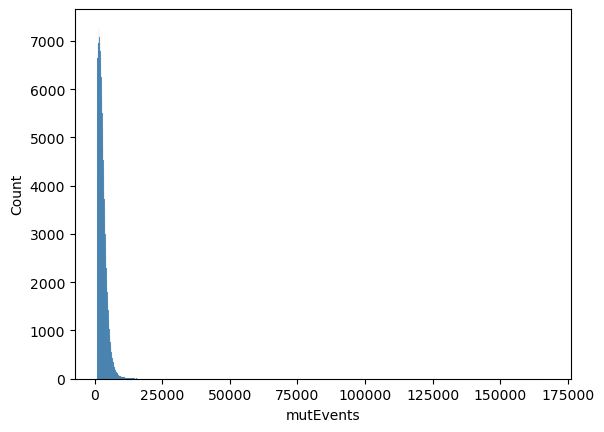

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


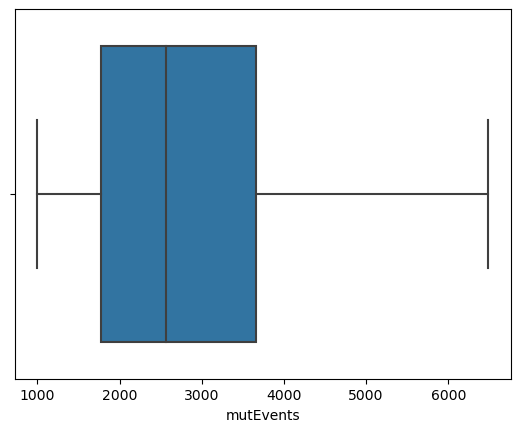

Min: 1001.000
Q1: 1772.000
Median: 2571.000
Q3: 3658.000
Max: 167757.000
Number of reads range from min 1001 to max 167757


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import percentile

barcode_mut_counts_all = df[["mutEvents"]].groupby(level=["Alias", "Gene", "Barcode"]).max()
sns.histplot(barcode_mut_counts_all["mutEvents"])
plt.show()

sns.boxplot(barcode_mut_counts_all["mutEvents"], showfliers = False)
plt.show()


quartiles = percentile(barcode_mut_counts_all["mutEvents"], [25, 50, 75])
# calculate min/max
data_min, data_max = barcode_mut_counts_all["mutEvents"].min(), barcode_mut_counts_all["mutEvents"].max()
# print 5-number summary
print('Min: %.3f' % data_min)
print('Q1: %.3f' % quartiles[0])
print('Median: %.3f' % quartiles[1])
print('Q3: %.3f' % quartiles[2])
print('Max: %.3f' % data_max)

print("Number of reads range from min {} to max {}".format(barcode_mut_counts_all["mutEvents"].min(), barcode_mut_counts_all["mutEvents"].max()))

In [22]:
print("total number of barcodes, ", barcode_mut_counts_all["mutEvents"].shape[0])
print("total number of barcodes > 200 mutagenic reads, ", (barcode_mut_counts_all["mutEvents"] > 200).sum())
print("total number of barcodes > 1000 mutagenic reads, ", (barcode_mut_counts_all["mutEvents"] > 1000).sum())

total number of barcodes,  522951
total number of barcodes > 200 mutagenic reads,  522859
total number of barcodes > 1000 mutagenic reads,  432096


In [3]:
barcode_mut_counts = barcode_mut_counts_all[barcode_mut_counts_all["mutEvents"] > 200]
print(barcode_mut_counts.index.get_level_values('Gene').unique().shape)

barcode_mut_counts = barcode_mut_counts_all[barcode_mut_counts_all["mutEvents"] > 500]
print(barcode_mut_counts.index.get_level_values('Gene').unique().shape)

barcode_mut_counts = barcode_mut_counts_all[barcode_mut_counts_all["mutEvents"] > 1000]
print(barcode_mut_counts.index.get_level_values('Gene').unique().shape)

(18115,)
(18115,)
(18115,)


In [31]:
import numpy as np

barcode_mut_counts = barcode_mut_counts_all[barcode_mut_counts_all["mutEvents"] > 500]
print(barcode_mut_counts.index.get_level_values('Gene').unique().shape)

common_barcodes = []
for alias in barcode_mut_counts.index.get_level_values("Alias").unique():
    common_barcodes.append(barcode_mut_counts.loc[alias].index.get_level_values("Barcode").to_list())

from functools import reduce
common_barcodes = reduce(np.intersect1d, common_barcodes)
np.unique(common_barcodes).shape

(18332,)


(77398,)

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, '615'),
 Text(0, 0, '892'),
 Text(0, 0, '1677'),
 Text(0, 0, '4195'),
 Text(0, 0, '10609'),
 Text(0, 0, '32'),
 Text(0, 0, '29'),
 Text(0, 0, '17'),
 Text(0, 0, '17'),
 Text(0, 0, '19'),
 Text(0, 0, '5'),
 Text(0, 0, '1'),
 Text(0, 0, '4'),
 Text(0, 0, '1'),
 Text(0, 0, '2')]

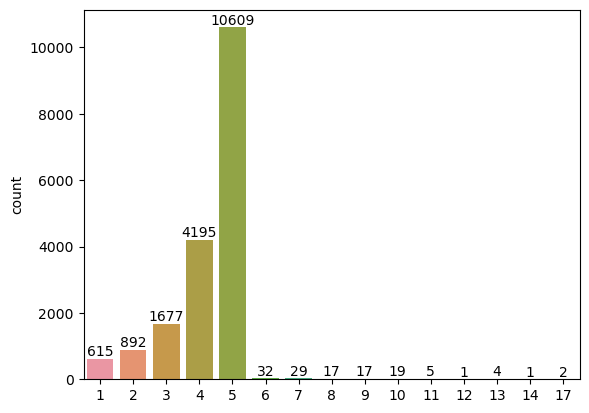

In [27]:
gene_barcode_counts = barcode_mut_counts.groupby(["Gene", "Barcode"]).size().groupby("Gene").size()
gene_barcode_counts
gene_barcode_counts[gene_barcode_counts == gene_barcode_counts.max()]
ax = sns.countplot(gene_barcode_counts)
# gene_barcode_counts.value_counts()
ax.bar_label(ax.containers[0])

So, we can see at this point, when we filter at 200 mutagenic reads per KO sgRNA, we get 16966 KO sgRNAs. We would like to filter out gRNAs that are very obviously outliers. To do this, we must: 
- Decide on an appropriate repair outcome profile, by deciding what outcomes we should be included. See `29022022_outcome_analysis.ipynb`
- Decide on how big the sample size should be before we can even detect outliers
- Decide what metric should we be using to calculate outliers

In [28]:
import pandas as pd

once_only_outcomes = outcome_counts_one_per_gene[outcome_counts_one_per_gene == 1]
once_only_outcomes = once_only_outcomes.index.to_series().str.split("|", expand=True).rename(columns={0: "Type", 1: "delRelativeStart", 2: "delRelativeEnd", 3: "misc"})

NameError: name 'outcome_counts_one_per_gene' is not defined

In [ ]:
once_only_outcomes["Type"].value_counts()

DELINS                        169126
TINS                          133603
INSERTION                      92808
TANDEMDUPLICATION_COMPOUND      7655
DELETION                        1079
HDR                               66
TANDEMDUPLICATION                 23
Name: Type, dtype: int64

In [ ]:
from numpy import percentile

num_genes = df_norm.index.get_level_values("Gene").unique().shape[0]
outcomes = (df_norm.groupby("outcome").sum().div(num_genes))
print("There are {} unique outcomes".format(outcomes.shape[0]))


quartiles = percentile(outcomes, [25, 50, 75])
# calculate min/max
data_min, data_max = outcomes.min(), outcomes.max()
# print 5-number summary
print('Min: %.10f' % data_min)
print('Q1: %.10f' % quartiles[0])
print('Median: %.10f' % quartiles[1])
print('Q3: %.10f' % quartiles[2])
print('Max: %.10f' % data_max)

There are 513246 unique outcomes
Min: 0.0000000006
Q1: 0.0000000229
Median: 0.0000000442
Q3: 0.0000000940
Max: 0.4680842033


<AxesSubplot:ylabel='Count'>

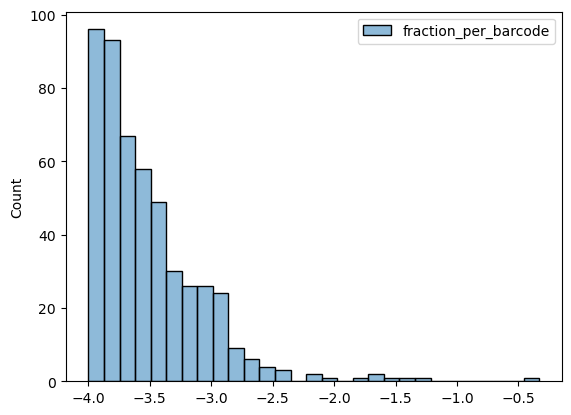

In [ ]:
from numpy import log10

sns.histplot(log10(outcomes[outcomes > 0.0001]))